In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from operator import add
from functools import reduce
from itertools import product


def pca(X):
    Xt = np.array(X).transpose()
    co = np.cov(Xt)
    w, v = np.linalg.eig(co)
    si = w.argsort()[::-1]
    w, v = w[si], v[:, si]
    x1 = v[:, 0].dot(Xt) / 3
    x2 = v[:, 1].dot(Xt) / 3
    return np.dstack((x1, x2))[0]


def vectorizeStrings(l):
    return reduce(add, list(map(lambda s: list(map(int, s.strip())), l)))


def blockSum_Pool(bits):
    mat = np.array(bits).reshape(32, 32)
    features = []
    for i in range(0, 32, 4):
        for j in range(0, 32, 4):
            features.append(np.sum(mat[i:i+4,j:j+4]))
    return features


def getDistance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))


def readDataset():
    f = open('optdigits-orig.tra')
    inputs = f.readlines()[21:]
    if not inputs[-1]: inputs = inputs[:-1]
    data = [inputs[x : x + 33] for x in range(0, len(inputs), 33)]

    bits = list(map(lambda d: vectorizeStrings(d[:-1]), data))
    labels = list(map(lambda d: int(d[32].strip()), data))

    threes = filter(lambda p: p[1] == 3, zip(bits, labels))
    imgt, _ = zip(*threes)
    features = list(map(blockSum_Pool, imgt))
    return features, imgt


def select(xc, yc, x):
    c = list(product(xc, yc)) # selected points

    minDist = list(map(lambda x: 99999, range(len(c)))) # neighbors' distance
    neighborsPoints = list(map(lambda x: [0, 0], range(len(c)))) # neighbors' x
    neighborsIndices = list(map(lambda x: -1, range(len(c)))) # neighbors' index

    for t, xs in enumerate(x):
        for k, cs in enumerate(c):
            dist = getDistance(xs, cs)
            if dist < minDist[k]:
                minDist[k] = dist
                neighborsPoints[k] = xs
                neighborsIndices[k] = t
    
    return neighborsPoints, neighborsIndices

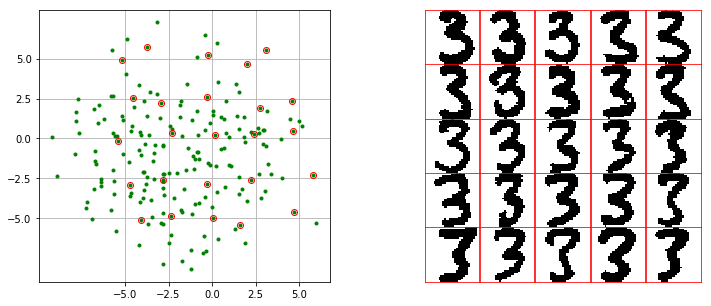

In [7]:
features, img = readDataset()
x = pca(features)

xc = [-5, -2.5, 0, 2.5, 5]
yc = [-5, -2.5, 0, 2.5, 5]
neighborsPoints, neighborsIndices = select(xc, yc, x)

fig = plt.figure(figsize=(12, 5))
outer = gridspec.GridSpec(1, 2, wspace=0.3)

# draw scatter plot
leftSpec = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
leftAx = plt.Subplot(fig, leftSpec[0])
x, y = zip(*x)
xp, yp = zip(*neighborsPoints)
leftAx.set_xticks(xc)
leftAx.set_yticks(xc)
leftAx.plot(x, y, 'g.')
leftAx.plot(xp, yp, 'ro', mfc='none')
leftAx.grid(True)
fig.add_subplot(leftAx)

# draw images
rightSpec = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=outer[1], wspace=-0.2, hspace=0)
for k, t in enumerate(neighborsIndices):
    rightAx = plt.Subplot(fig, rightSpec[k])
    rightAx.imshow(np.array(img[t]).reshape(32, 32), cmap='gray_r')
    rightAx.set_xticks([])
    rightAx.set_yticks([])
    for spine in rightAx.spines.values():
        spine.set_color('red')
    fig.add_subplot(rightAx)

plt.show()